In [170]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/zyuanjue/repos/active-learning/mnistvae


In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions



BATCH_SIZE = 16

2023-11-26 19:05:22.062424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 19:05:22.062462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 19:05:22.063887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 19:05:23.073814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [3]:
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

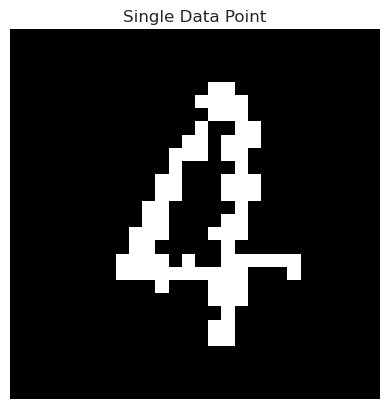

In [4]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [5]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)


step/epoch: 1/0	 distortion: 0.694	 loss: 0.694	 rate: 0.000
step/epoch: 2/0	 distortion: 0.690	 loss: 0.690	 rate: 0.000
step/epoch: 3/0	 distortion: 0.685	 loss: 0.685	 rate: 0.000
step/epoch: 4/0	 distortion: 0.679	 loss: 0.679	 rate: 0.000
step/epoch: 5/0	 distortion: 0.667	 loss: 0.667	 rate: 0.000
step/epoch: 6/0	 distortion: 0.648	 loss: 0.650	 rate: 0.002
step/epoch: 7/0	 distortion: 0.599	 loss: 0.606	 rate: 0.007
step/epoch: 8/0	 distortion: 0.506	 loss: 0.525	 rate: 0.019
step/epoch: 9/0	 distortion: 0.510	 loss: 0.566	 rate: 0.057
step/epoch: 10/0	 distortion: 0.437	 loss: 0.478	 rate: 0.042
step/epoch: 11/0	 distortion: 0.474	 loss: 0.497	 rate: 0.023
step/epoch: 12/0	 distortion: 0.453	 loss: 0.463	 rate: 0.010
step/epoch: 13/0	 distortion: 0.430	 loss: 0.433	 rate: 0.003
step/epoch: 14/0	 distortion: 0.394	 loss: 0.396	 rate: 0.001
step/epoch: 15/0	 distortion: 0.395	 loss: 0.396	 rate: 0.001
step/epoch: 16/0	 distortion: 0.372	 loss: 0.372	 rate: 0.000
step/epoch: 17/0	

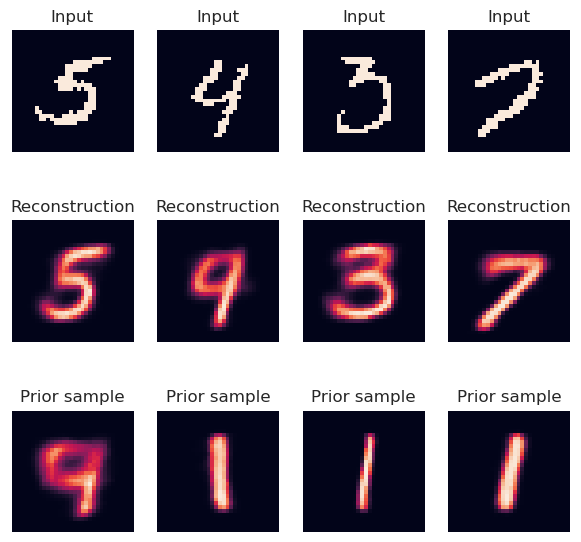

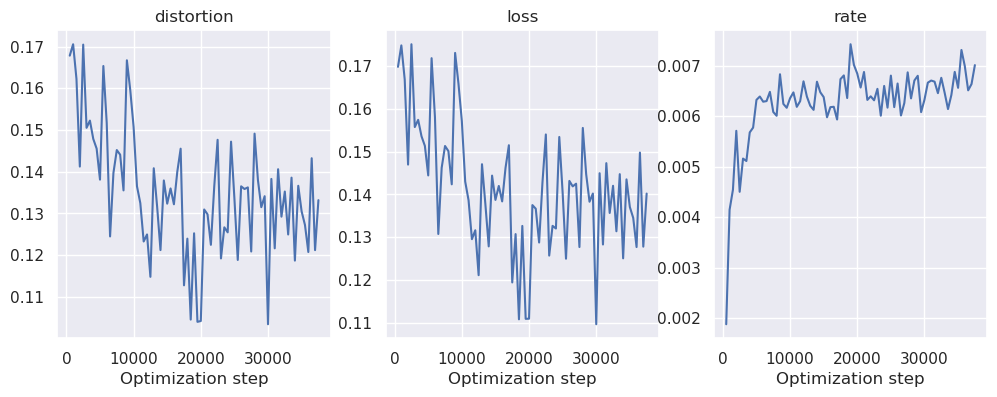

In [6]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)



@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state

MAX_EPOCHS = 10
steps_per_epoch = 60000 // batch_size 

step = 0  
train_metrics = None

for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch = np.squeeze(batch)
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

        log_str = f"step/epoch: {step}/{epoch}"
        for k, v in aux.items():
            log_str += f"\t {k}: {v:.3f}"
        print(log_str)

        # Check if the epoch is completed
        if step % steps_per_epoch == 0:
            break  # End the current epoch

# Reset step for the next epoch or other post-epoch processing


visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

In [171]:
from acquiring.sample_image import sample_a_image, get_next,update_images, binary_cross_entropy

In [172]:
BATCH_SIZE = 128
train_dataloader = load_dataset(tfds.Split.TRAIN, BATCH_SIZE)
batch = next(train_dataloader)
batch['image'].shape

2023-11-26 22:10:40.468839: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

In [173]:
#Pre_Process:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)


model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [180]:
def update(images_refill: jnp.ndarray, orginial_images: jnp.ndarray, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    R = sample_a_image_fn(Nz, Nx,model_output,model, batch_rng)
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    return images_updated, mask_return

In [175]:
from acquiring.sample_image import random_get_next


In [181]:

from acquiring.sample_image import random_get_next

def random_update(original_images,images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, original_images, rng)

    return images_updated, mask_return

In [193]:

num_batches_to_process = 2
display_batch_number = 0 
batch_counter = 0
log_likelihood = []
random_value = []
for batch_index, batch in enumerate(train_dataloader):
    # Load and preprocess the batch
    original_images = np.squeeze(batch['image'])
    original_images = original_images.astype(np.float32)
    images_float = original_images
    half_height = images_float.shape[1] // 2

    # Create mask and images with missing data
    images_with_top_half_missing = images_float.copy()
    images_with_top_half_missing[:, :half_height, :] = np.nan
    mask_missing = np.isnan(images_with_top_half_missing)
    mask_observed = ~mask_missing


    images_refill = update_images_fn(original_images, mask_observed)
    mask_observed = pad_fn(mask_observed)
    images_refill = pad_fn(images_refill)
    original_images= pad_fn(original_images)


    current_images = images_refill
    current_mask = mask_observed

    steps = 20  # Log likelihood calculation frequency
    step_counter = 0
    max_step = 300
    recon_value = []
    step_numbers = []


    if batch_index == display_batch_number:
        original_random = original_images.copy()
        images_random = images_refill.copy() 
        mask_random = mask_observed.copy()

    # Processing loop
    while np.any(~mask_observed) and step_counter < max_step:
        current_images, current_mask = update(images_refill, original_images, current_images, current_mask, key)
        

        if step_counter % steps == 0 :
            # Log likelihood calculation for reconstruction
            new_log_likelihood_recon = -binary_cross_entropy(original_images, current_images)
            log_likelihood.append(-new_log_likelihood_recon[0])
            print(f"Step {step_counter}:  Log Likelihood = {new_log_likelihood_recon[0]}")
            if batch_index == display_batch_number:
                recon_value.append(new_log_likelihood_recon)
                step_numbers.append(step_counter)
            #get plot for the first image
            # if step_counter < 100:
            #     plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
            #     plt.colorbar()
            #     plt.show()
        step_counter += 1
    

    batch_counter += 1

    # Break the loop if the desired number of batches have been processed
    if batch_counter >= num_batches_to_process:
        break



Step 0:  Log Likelihood = -694.20751953125
Step 20:  Log Likelihood = -690.78857421875
Step 40:  Log Likelihood = -686.98974609375
Step 60:  Log Likelihood = -683.5706787109375
Step 80:  Log Likelihood = -680.1517333984375
Step 100:  Log Likelihood = -679.3919677734375
Step 120:  Log Likelihood = -679.3919677734375
Step 140:  Log Likelihood = -679.3919677734375
Step 160:  Log Likelihood = -679.3919677734375
Step 180:  Log Likelihood = -679.3919677734375
Step 200:  Log Likelihood = -679.3919677734375
Step 220:  Log Likelihood = -679.3919677734375
Step 240:  Log Likelihood = -679.3919677734375
Step 260:  Log Likelihood = -679.3919677734375
Step 280:  Log Likelihood = -679.3919677734375
Step 0:  Log Likelihood = -686.2299194335938
Step 20:  Log Likelihood = -682.8109130859375
Step 40:  Log Likelihood = -676.7327880859375
Step 60:  Log Likelihood = -673.6936645507812
Step 80:  Log Likelihood = -671.4143676757812
Step 100:  Log Likelihood = -669.8948364257812
Step 120:  Log Likelihood = -66

In [101]:
reshaped_batches =jnp.array(log_likelihood).reshape(num_batches_to_process, step_counter // steps, BATCH_SIZE).transpose(1, 0, 2)

combined_batches = reshaped_batches.reshape(step_counter // steps, num_batches_to_process * BATCH_SIZE ) # shape is (15, n*128)

std_dev_each_step = np.std(combined_batches, axis=1, keepdims=True)

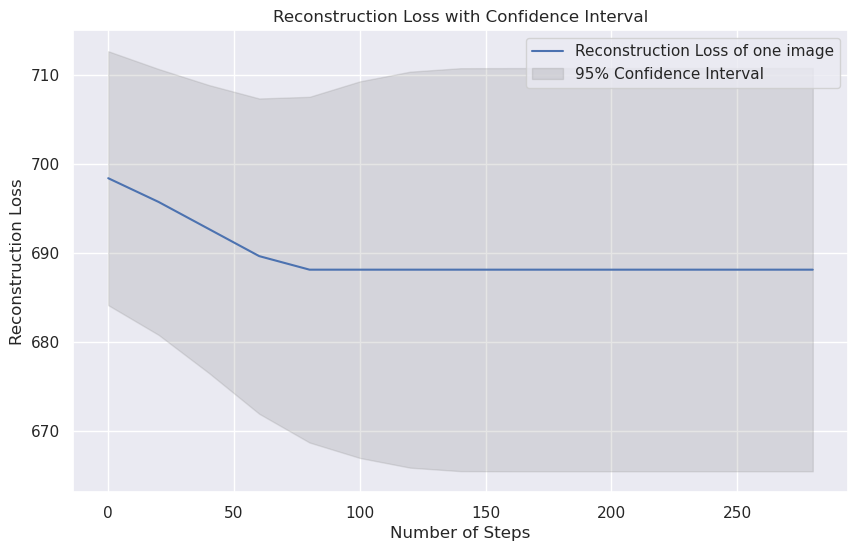

In [102]:
recon_value = np.array(recon_value)
std_deviation = std_dev_each_step

ci = 1.96 * std_deviation.flatten()  # Flatten to ensure it's a 1D array
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Reconstruction Loss of one image')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [196]:

from acquiring.sample_image import random_get_next
def random_update(original_images, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, original_images, rng)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -721.58740234375


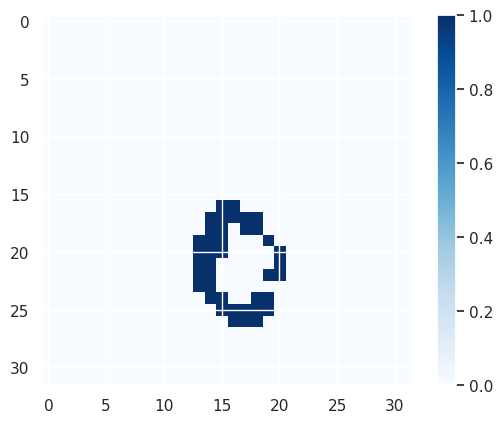

Step 20: Mean Log Likelihood = -721.58740234375


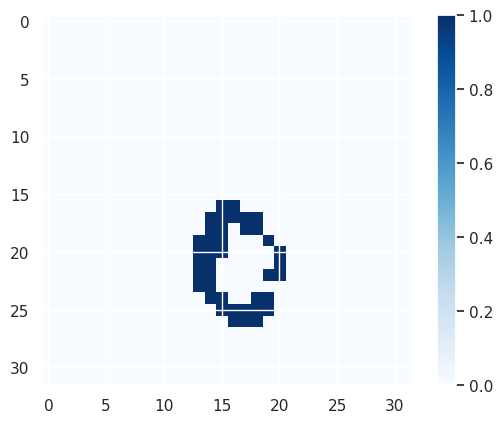

Step 40: Mean Log Likelihood = -721.58740234375


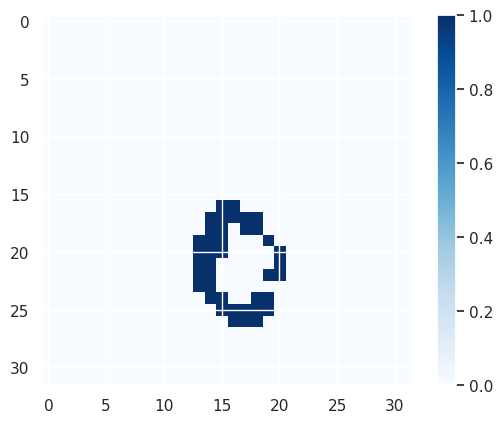

Step 60: Mean Log Likelihood = -721.58740234375


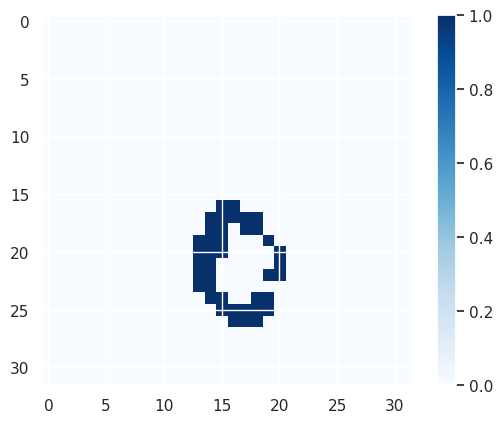

Step 80: Mean Log Likelihood = -721.58740234375


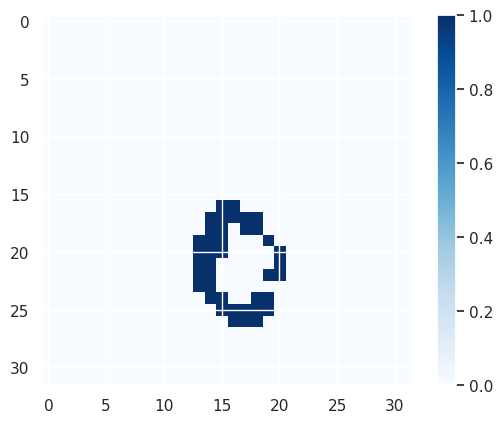

Step 100: Mean Log Likelihood = -721.58740234375
Step 120: Mean Log Likelihood = -721.58740234375
Step 140: Mean Log Likelihood = -721.58740234375
Step 160: Mean Log Likelihood = -721.58740234375
Step 180: Mean Log Likelihood = -721.58740234375
Step 200: Mean Log Likelihood = -721.58740234375
Step 220: Mean Log Likelihood = -721.58740234375
Step 240: Mean Log Likelihood = -721.58740234375
Step 260: Mean Log Likelihood = -721.58740234375
Step 280: Mean Log Likelihood = -721.58740234375


In [197]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 10  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 200
random_value = []
step_numbers = [] 
while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = random_update(current_images, current_mask, key)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(orginial_images, current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        random_value.append(-mean_log_likelihood)
        step_numbers.append(step_counter)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
    if step_counter % steps == 0 and step_counter < 100:
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()

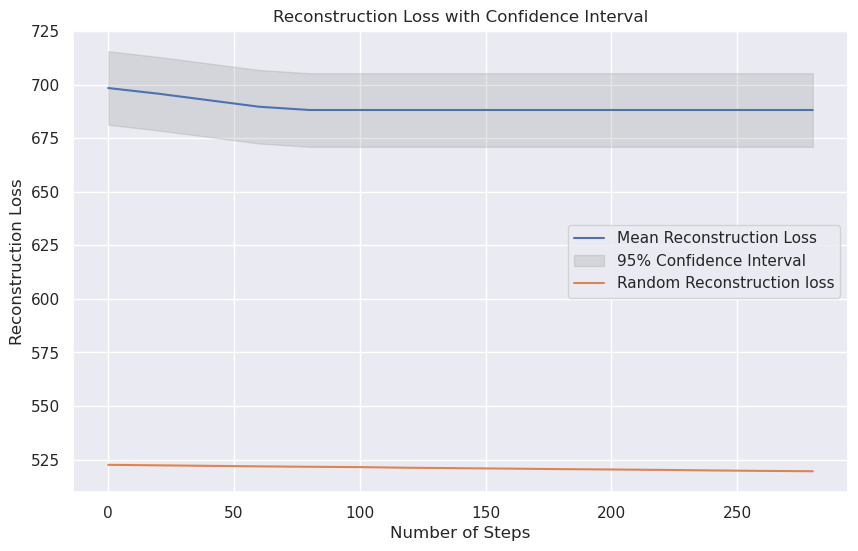

In [108]:
recon_value = np.array(recon_value)
std_deviation = jnp.std(new_log_likelihood)

# Calculate the upper and lower bounds of the confidence interval
ci = 1.96 * std_deviation  # 95% confidence interval for a normal distribution
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Mean Reconstruction Loss')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.plot(step_numbers, random_value, label= "Random Reconstruction loss" )
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [56]:
# batch_rng = jax.random.split(key, batch_size) 
# model_output: ImageVAEOutput = model_fn(orginial_images, key=batch_rng)
# reconstruction = model_output["observation_distribution"].sample(seed=key)
# init_loss = -binary_cross_entropy(orginial_images, np.squeeze(reconstruction))
# jnp.mean(init_loss)

Array(-714.7327, dtype=float32)